In [1]:
SEED = 61

import numpy as np
import tensorflow as tf
import random as python_random
import os

def reset_seeds():
    np.random.seed(SEED) 
    python_random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    
import os
import re
import gc
import tensorflow_addons as tfa
import h5py
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm
from nltk import tokenize

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from keras import backend as K
from keras import initializers,regularizers,constraints
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Reshape, Input, Embedding, Flatten, Dense, Dropout, BatchNormalization, Activation #, merge
from keras.layers import TimeDistributed, LSTM, GRU, Bidirectional, Convolution1D, MaxPooling1D, MaxPooling2D
from keras.layers.core import RepeatVector #, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, Model, load_model
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.model_selection import cross_val_score

from tensorflow.python.keras.layers import Layer, InputSpec, Lambda

from transformers import BertTokenizer, BertForMaskedLM, BertModel

# from tensorflow.keras import Model
# from attention import Attention_input1, Attention_input2
# from keras.optimizers import SGD, RMSprop, Adagrad

In [2]:
def read_hdf5(path):
    read_file = h5py.File(path, 'r')
    
    feature_names = list(read_file.keys())
    loaded_data = []
    
    for name in feature_names:
        dataset = read_file[name][:]
        if dataset.dtype == np.dtype('object'):
            dataset = np.array([x.decode('UTF-8') for x in dataset])            
        loaded_data.append((name, dataset))

    return loaded_data

def loadz(path):
    data = np.load(path)['arr_0']
    return data

In [3]:
def load_labels(path):
    data = read_hdf5(path)

    for x in data:
        if x[0] == 'multimodal-labels':
            labels = x[1]
        if x[0] == 'text-labels':
            text_labels = x[1]
        if x[0] == 'image-labels':
            image_labels = x[1]
        
    return labels, text_labels, image_labels

def merge_mvsa(mvsa_single, mvsa_multiple):
    mvsa = np.concatenate((mvsa_single, mvsa_multiple), axis=0)
    return mvsa

def load_mvsa_feature(feature_name, merge=False):
    folder_path = os.path.join('../input/mvsa-features/', feature_name)
    single_file = 'mvsa-single-{}.npz'.format(feature_name)
    multiple_file = 'mvsa-multiple-{}.npz'.format(feature_name)
    mvsa_single = loadz(os.path.join(folder_path, single_file))
    mvsa_multiple = loadz(os.path.join(folder_path, multiple_file))
    
    if merge == True:
        return merge_mvsa(mvsa_single, mvsa_multiple)
    
    return mvsa_single, mvsa_multiple

In [4]:
# e.g. validation_split=0.1 -----> 8:1:1 ratio of train, val, test
def split_data(data, validation_split):
    num_val = int(validation_split * data.shape[0])
    data_train = data[:-(num_val*2)]
    data_val = data[-(num_val*2):-(num_val)]
    data_test = data[-num_val:]
    return data_train, data_val, data_test

In [5]:
def create_model_IF(text_shape, image_shape):
    f1_score = tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro')
    
    image_input = Input(shape=image_shape)
    text_input = Input(shape=text_shape)
    text_reshape = Reshape((1, -1)) (text_input)
    text_lstm = LSTM(DIM_LSTM) (text_reshape)
#     text_lstm = Dropout(DROPOUT_RATE) (text_lstm)
    text_image_concat = tf.keras.layers.Concatenate(axis=1)([text_lstm, image_input])
    concat_self_attention = tf.keras.layers.Attention() ([text_image_concat, text_image_concat])
#     concat_self_attention = Dropout(DROPOUT_RATE) (concat_self_attention)
    concat_softmax = Dense(NUM_CLASSES, activation='softmax') (concat_self_attention)
    
    model = Model([text_input, image_input], concat_softmax)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score]) # f1 #tf.keras.metrics.AUC()
    
    return model

In [6]:
def evaluate_model(model, X_texts, X_images, y_test, checkpoint=None, verbose=1):
    if checkpoint is not None:
        model = load_model('./model_checkpoint/{}.h5'.format(checkpoint))#, custom_objects={'f1': f1})
    
    loss, acc, f1 = model.evaluate([X_texts, X_images], y_test, verbose=verbose)

    if verbose == 1:
        print('Loss:', loss)
        print('Accuracy:', acc)
        print('F1-score:', f1)
        y_pred = model.predict([X_texts, X_images])
        matrix = confusion_matrix(le.inverse_transform(y_test.argmax(axis=1)), le.inverse_transform(y_pred.argmax(axis=1)), 
                                  labels=list(le.classes_))
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                                  display_labels=list(le.classes_))
        cm_disp.plot()
        plt.show()
        
    return loss, acc, f1

In [7]:
def run_and_evaluate(name, X1, X2, y, verbose=0):
    ''' 
    X1: text input
    X2: image input
    '''
    y = le.fit_transform(y)
    y = to_categorical(np.asarray(y))
    
    X1_train, X1_val, X1_test = split_data(X1, VALIDATION_SPLIT)
    X2_train, X2_val, X2_test = split_data(X2, VALIDATION_SPLIT)
    y_train, y_val, y_test = split_data(y, VALIDATION_SPLIT)
    
    model = create_model_IF(X1_train.shape[1:], X2_train.shape[1:])
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=EARLY_STOPPING)
    checkpoint = ModelCheckpoint('./model_checkpoint/{}.h5'.format(name), save_best_only=True, verbose=verbose)
    
    history = model.fit([X1_train, X2_train], y_train, validation_data=([X1_val, X2_val], y_val), 
                        epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=verbose,
                        callbacks=[checkpoint, early_stopping])
    
    best_epoch = np.argmin(history.history['val_loss'])
    print('Checkpoint loaded at epoch:', best_epoch)
    return history, evaluate_model(model, X1_test, X2_test, y_test, checkpoint=name, verbose=verbose)

In [8]:
def plot_metrics(history):
    fig = plt.figure(figsize=(20, 5))

    fig.add_subplot(1, 3, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('LOSS')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    fig.add_subplot(1, 3, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('ACCURACY')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    fig.add_subplot(1, 3, 3)
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('F1-SCORE')
    plt.ylabel('f1-score')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    plt.show()

# Load data

In [9]:
## Choose best
# Load text feature
mvsa_single_bert_base, mvsa_multiple_bert_base = load_mvsa_feature('bert-base')
mvsa_single_pos_bow, mvsa_multiple_pos_bow = load_mvsa_feature('pos-bow')
# mvsa_single_pos_tfidf, mvsa_multiple_pos_tfidf = load_mvsa_feature('pos-tfidf')
# mvsa_single_ner_bow, mvsa_multiple_ner_bow = load_mvsa_feature('ner-bow')
# mvsa_single_ner_tfidf, mvsa_multiple_ner_tfidf = load_mvsa_feature('ner-tfidf')

## Load image feature
# mvsa_single_vgg16, mvsa_multiple_vgg16 = load_mvsa_feature('vgg16')
# mvsa_single_vgg19, mvsa_multiple_vgg19 = load_mvsa_feature('vgg19')
# mvsa_single_resnet50, mvsa_multiple_resnet50 = load_mvsa_feature('resnet50')
# mvsa_single_resnet101, mvsa_multiple_resnet101 = load_mvsa_feature('resnet101')
# mvsa_single_resnet152, mvsa_multiple_resnet152 = load_mvsa_feature('resnet152')
# mvsa_single_densenet121, mvsa_multiple_densenet121 = load_mvsa_feature('densenet121')
# mvsa_single_densenet169, mvsa_multiple_densenet169 = load_mvsa_feature('densenet169')
mvsa_single_densenet201, mvsa_multiple_densenet201 = load_mvsa_feature('densenet201')

In [10]:
mvsa_single_multimodal_labels, mvsa_single_text_labels, mvsa_single_image_labels = load_labels('../input/mvsa-features/labels/mvsa-single-labels.hdf5')
mvsa_multiple_multimodal_labels, mvsa_multiple_text_labels, mvsa_multiple_image_labels = load_labels('../input/mvsa-features/labels/mvsa-multiple-labels.hdf5')

In [11]:
mvsa_single_text_features = np.concatenate((mvsa_single_bert_base, mvsa_single_pos_bow), axis=1)
mvsa_multiple_text_features = np.concatenate((mvsa_multiple_bert_base, mvsa_multiple_pos_bow), axis=1)

mvsa_single_image_features = mvsa_single_densenet201
mvsa_multiple_image_features = mvsa_multiple_densenet201

print('Text vector shape:', mvsa_single_text_features.shape[1:])
print('Image vector shape:', mvsa_single_image_features.shape[1:])

Text vector shape: (802,)
Image vector shape: (1920,)


In [12]:
le = preprocessing.LabelEncoder()
le.fit(mvsa_single_multimodal_labels)
NUM_CLASSES = len(le.classes_) # = 3

In [13]:
reset_seeds()
EPOCHS = 100
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.1
EARLY_STOPPING = 100
DIM_LSTM = 128
DROPOUT_RATE = 0.2

2022-06-30 20:35:52.595223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 20:35:52.596326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 20:35:52.597042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 20:35:52.597880: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/100


2022-06-30 20:36:00.936446: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


27/27 [==============================] - 4s 23ms/step - loss: 0.9852 - accuracy: 0.5463 - f1_score: 0.3390 - val_loss: 0.8184 - val_accuracy: 0.5963 - val_f1_score: 0.4061

Epoch 00001: val_loss improved from inf to 0.81843, saving model to ./model_checkpoint/single-IF.h5
Epoch 2/100
27/27 [==============================] - 0s 6ms/step - loss: 0.7858 - accuracy: 0.6488 - f1_score: 0.4848 - val_loss: 0.7852 - val_accuracy: 0.6450 - val_f1_score: 0.4915

Epoch 00002: val_loss improved from 0.81843 to 0.78522, saving model to ./model_checkpoint/single-IF.h5
Epoch 3/100
27/27 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.7113 - f1_score: 0.5866 - val_loss: 0.7601 - val_accuracy: 0.6659 - val_f1_score: 0.4908

Epoch 00003: val_loss improved from 0.78522 to 0.76012, saving model to ./model_checkpoint/single-IF.h5
Epoch 4/100
27/27 [==============================] - 0s 5ms/step - loss: 0.6306 - accuracy: 0.7336 - f1_score: 0.6353 - val_loss: 0.7283 - val_accuracy

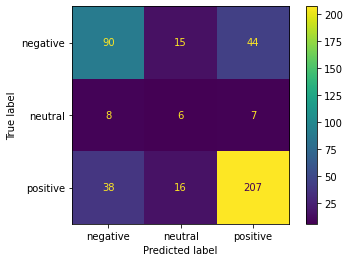

In [14]:
history, scores = run_and_evaluate('single-IF', mvsa_single_text_features, mvsa_single_image_features, mvsa_single_multimodal_labels, verbose=1)

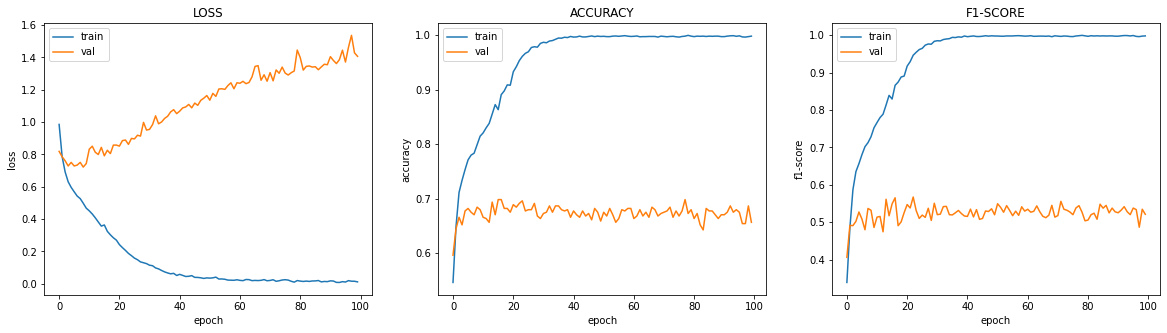

In [15]:
plot_metrics(history)

Epoch 1/100
103/103 [==============================] - 2s 9ms/step - loss: 0.8250 - accuracy: 0.6491 - f1_score: 0.3701 - val_loss: 0.6955 - val_accuracy: 0.7338 - val_f1_score: 0.3702

Epoch 00001: val_loss improved from inf to 0.69549, saving model to ./model_checkpoint/multiple-IF.h5
Epoch 2/100
103/103 [==============================] - 0s 5ms/step - loss: 0.7076 - accuracy: 0.6848 - f1_score: 0.4800 - val_loss: 0.6615 - val_accuracy: 0.7289 - val_f1_score: 0.4688

Epoch 00002: val_loss improved from 0.69549 to 0.66152, saving model to ./model_checkpoint/multiple-IF.h5
Epoch 3/100
103/103 [==============================] - 1s 5ms/step - loss: 0.6852 - accuracy: 0.6913 - f1_score: 0.5053 - val_loss: 0.6616 - val_accuracy: 0.7363 - val_f1_score: 0.4583

Epoch 00003: val_loss did not improve from 0.66152
Epoch 4/100
103/103 [==============================] - 0s 5ms/step - loss: 0.6610 - accuracy: 0.7047 - f1_score: 0.5273 - val_loss: 0.6598 - val_accuracy: 0.7332 - val_f1_score: 0.482

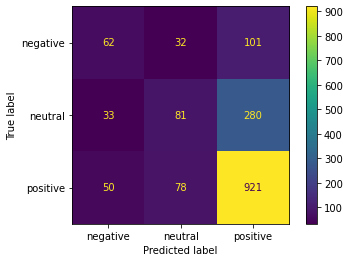

In [16]:
history2, scores2 = run_and_evaluate('multiple-IF', mvsa_multiple_text_features, mvsa_multiple_image_features, mvsa_multiple_multimodal_labels, verbose=1)

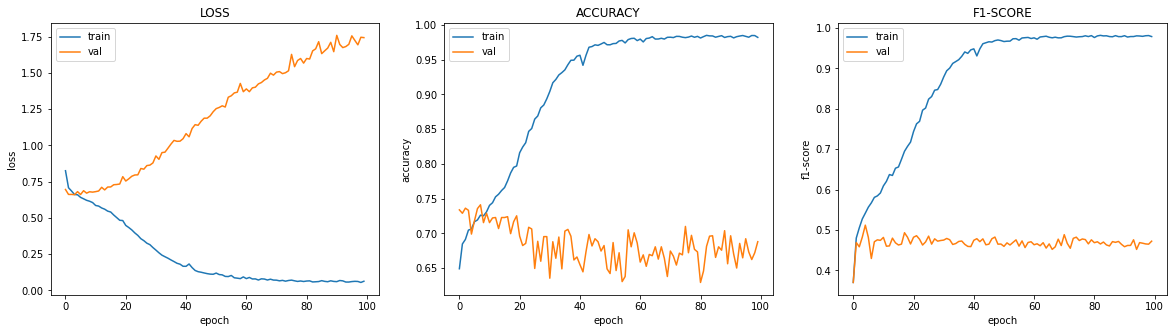

In [17]:
plot_metrics(history2)

# Drafts

In [18]:
# def f1(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val